In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import mediapipe as mp
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

In [31]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [32]:
class PairedImageDataset(Dataset):
    def __init__(self, root_dir, phase, grayscale_transform=None, color_transform=None):
        self.grayscale_dir = os.path.join(root_dir, phase, 'grayscale')
        self.color_dir = os.pjust ath.join(root_dir, phase, 'color')
        self.grayscale_transform = grayscale_transform
        self.color_transform = color_transform
        self.image_names = [f for f in os.listdir(self.grayscale_dir) if os.path.isfile(os.path.join(self.grayscale_dir, f))]
        
        # Collect labels
        self.labels = []
        self.valid_image_names = []
        for filename in self.image_names:
            if filename.startswith('grayscale_') or filename.startswith('color_'):
                parts = filename.split('_')
                try:
                    label = int(parts[1])
                    self.labels.append(label)
                    self.valid_image_names.append(filename)
                except ValueError:
                    continue
        
        self.image_names = self.valid_image_names

        # Create continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        grayscale_path = os.path.join(self.grayscale_dir, self.image_names[idx])
        color_path = os.path.join(self.color_dir, self.image_names[idx])

        grayscale_image = Image.open(grayscale_path).convert('L')
        color_image = Image.open(color_path).convert('RGB')

        if self.grayscale_transform:
            grayscale_image = self.grayscale_transform(grayscale_image)
        if self.color_transform:
            color_image = self.color_transform(color_image)

        label = self.labels[idx]
        return grayscale_image, color_image, label

grayscale_transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

color_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [33]:
# Create dataset instances
root_dir = 'dataset5_dual_data'
train_dataset = PairedImageDataset(root_dir, 'train', grayscale_transform, color_transform)
val_dataset = PairedImageDataset(root_dir, 'val', grayscale_transform, color_transform)
test_dataset = PairedImageDataset(root_dir, 'test', grayscale_transform, color_transform)

# Create dataloader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
# Model definition
class DualInputCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(DualInputCNN, self).__init__()

        # Grayscale CNN
        self.grayscale_cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )

        # Landmark CNN
        self.landmark_cnn = nn.Sequential(
            nn.Conv2d(1, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(50, 25, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(25),
            nn.Dropout2d(0.2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(32*3*3 + 25*10*1, 512)
        self.fc_dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)  # Assuming 10 classes

    def forward(self, grayscale, landmarks):
        # Grayscale pathway
        x1 = self.grayscale_cnn(grayscale)
        x1 = x1.view(-1, 32*3*3)

        # Color pathway
        x2 = self.landmark_cnn(landmarks)
        x2 = x2.view(-1, 25*10*1)

        # Concatenate and classify
        x = torch.cat((x1, x2), dim=1)
        x = self.fc_dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [35]:
def process_with_mediapipe(color_images):
    batch_landmarks = []
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).cpu().numpy()  # Move to CPU before converting to numpy
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
        # If no landmarks found or fewer than 21, fill with zeros
        while len(landmarks) < 21:
            landmarks.append([0.0, 0.0, 0.0])
        batch_landmarks.append(landmarks)
    landmarks_tensor = torch.tensor(batch_landmarks, dtype=torch.float32)
    return landmarks_tensor.view(len(color_images), 1, 21, 3).to(device)  # Move back to device


In [36]:
# Function to infer number of classes
def get_num_classes(dataset):
    """
    Get the number of unique classes in the dataset.

    Args:
        dataset (Dataset): The dataset to analyze.

    Returns:
        int: The number of unique classes.
    """
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [39]:
# Initialize MediaPipe
mp_hands = mp.solutions.hands.Hands(static_image_mode=True, max_num_hands=1)
# Model, Loss, Optimizer
model = DualInputCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Initialize lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with accuracy calculation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Training')

    for data in train_progress_bar:
        grayscale_images, color_images, labels = data

        # Move data to the device
        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        # Process color images to extract landmarks
        landmarks = process_with_mediapipe(color_images)

        optimizer.zero_grad()
        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        train_progress_bar.set_postfix({
            'loss': running_loss / (train_progress_bar.n + 1),
            'accuracy': correct_predictions / total_predictions
        })
    epoch_train_loss = running_loss/len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracy = 100*correct_predictions/total_predictions
    train_accuracies.append(train_accuracy)

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    all_labels = []
    all_predictions = []
    val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} Validation')

    with torch.no_grad():
        for data in val_progress_bar:
            grayscale_images, color_images, labels = data

            # Move data to the device
            grayscale_images = grayscale_images.to(device)
            color_images = color_images.to(device)
            labels = labels.to(device)

            # Process color images to extract landmarks
            landmarks = process_with_mediapipe(color_images)

            outputs = model(grayscale_images, landmarks)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            val_progress_bar.set_postfix({
                'val_loss': val_loss / (val_progress_bar.n + 1),
                'val_accuracy': val_correct_predictions / val_total_predictions
            })
    epoch_val_loss = val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    val_accuracies.append(val_accuracy)
    print(f'Epoch {epoch + 1}, Training loss: {running_loss / len(train_loader):.3f}, Training accuracy: {correct_predictions / total_predictions:.3f}, Validation loss: {val_loss / len(val_loader):.3f}, Validation accuracy: {val_correct_predictions / val_total_predictions:.3f}')

print('Finished Training')



I0000 00:00:1717515350.477378  162959 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M2
W0000 00:00:1717515350.489544  815970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717515350.506813  815970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Epoch 1/10 Training:   0%|          | 0/1439 [00:00<?, ?it/s]/opt/miniconda3/envs/cs221/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Epoch 1/10 Validation: 100%|██████████| 309/309 [05:52<00:00,  1.14s/it, val_loss=0.665, val_accuracy=0.779]


Epoch 1, Training loss: 1.453, Training accuracy: 0.534, Validation loss: 0.665, Validation accuracy: 0.779


Epoch 2/10 Validation: 100%|██████████| 309/309 [05:25<00:00,  1.05s/it, val_loss=0.36, val_accuracy=0.885] 


Epoch 2, Training loss: 0.707, Training accuracy: 0.766, Validation loss: 0.360, Validation accuracy: 0.885


Epoch 3/10 Validation: 100%|██████████| 309/309 [06:11<00:00,  1.20s/it, val_loss=0.25, val_accuracy=0.921] 


Epoch 3, Training loss: 0.489, Training accuracy: 0.836, Validation loss: 0.250, Validation accuracy: 0.921


Epoch 4/10 Validation: 100%|██████████| 309/309 [05:33<00:00,  1.08s/it, val_loss=0.183, val_accuracy=0.942]


Epoch 4, Training loss: 0.389, Training accuracy: 0.869, Validation loss: 0.183, Validation accuracy: 0.942


Epoch 5/10 Validation: 100%|██████████| 309/309 [05:35<00:00,  1.08s/it, val_loss=0.191, val_accuracy=0.943]


Epoch 5, Training loss: 0.319, Training accuracy: 0.893, Validation loss: 0.191, Validation accuracy: 0.943


Epoch 6/10 Validation: 100%|██████████| 309/309 [05:19<00:00,  1.03s/it, val_loss=0.139, val_accuracy=0.954]


Epoch 6, Training loss: 0.272, Training accuracy: 0.910, Validation loss: 0.139, Validation accuracy: 0.954


Epoch 7/10 Validation: 100%|██████████| 309/309 [04:32<00:00,  1.14it/s, val_loss=0.124, val_accuracy=0.959]


Epoch 7, Training loss: 0.239, Training accuracy: 0.919, Validation loss: 0.124, Validation accuracy: 0.959


Epoch 8/10 Validation: 100%|██████████| 309/309 [04:31<00:00,  1.14it/s, val_loss=0.118, val_accuracy=0.964]


Epoch 8, Training loss: 0.220, Training accuracy: 0.926, Validation loss: 0.118, Validation accuracy: 0.964


Epoch 9/10 Validation: 100%|██████████| 309/309 [04:24<00:00,  1.17it/s, val_loss=0.102, val_accuracy=0.968] 


Epoch 9, Training loss: 0.199, Training accuracy: 0.934, Validation loss: 0.102, Validation accuracy: 0.968


Epoch 10/10 Validation: 100%|██████████| 309/309 [04:54<00:00,  1.05it/s, val_loss=0.12, val_accuracy=0.965] 

Epoch 10, Training loss: 0.182, Training accuracy: 0.939, Validation loss: 0.120, Validation accuracy: 0.965
Finished Training


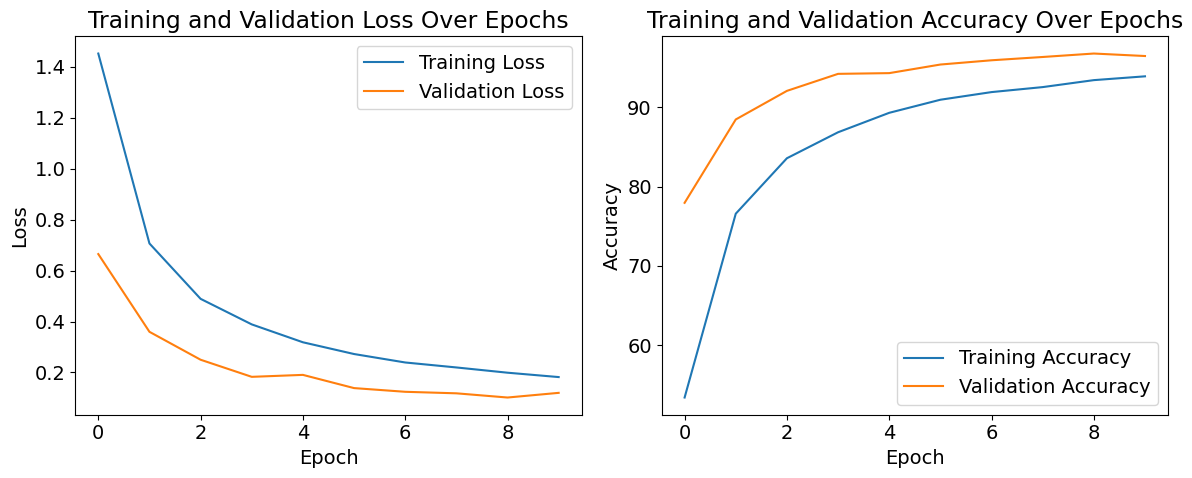

In [40]:
import matplotlib.pyplot as plt

# Set the default font size
plt.rcParams.update({'font.size': 14})

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


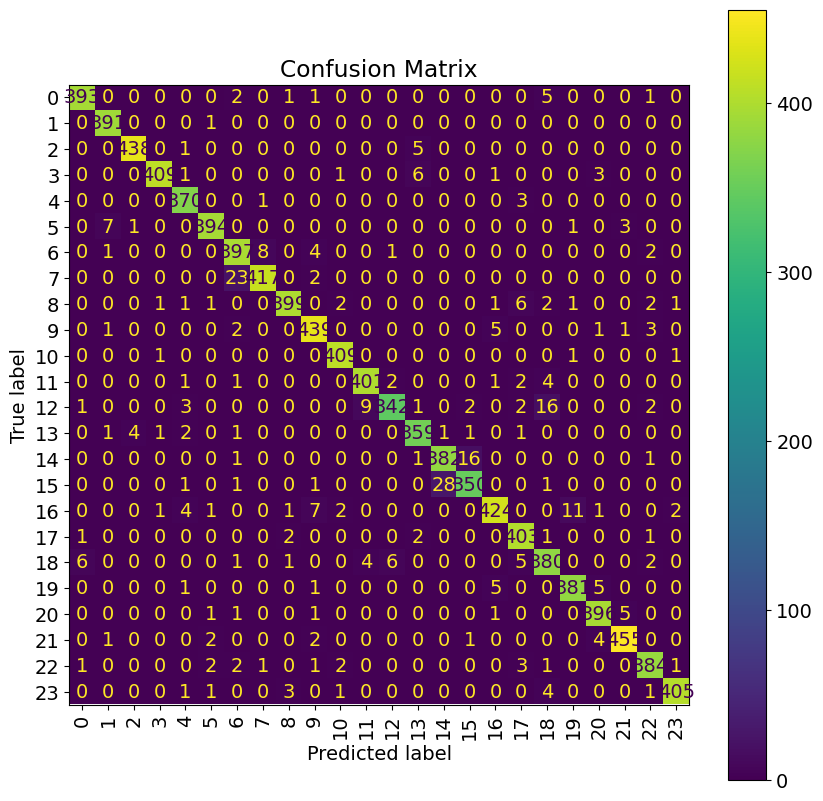

In [41]:
# Generate confusion matrix
num_classes = 24
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Print the classification report as a table
print(df_report)

# Save the classification report to a CSV file
df_report.to_csv('classification_report.csv', index=True)

              precision    recall  f1-score      support
Class 0        0.977612  0.975186  0.976398   403.000000
Class 1        0.972637  0.997449  0.984887   392.000000
Class 2        0.988713  0.986486  0.987599   444.000000
Class 3        0.990315  0.971496  0.980815   421.000000
Class 4        0.958549  0.989305  0.973684   374.000000
Class 5        0.977667  0.970443  0.974042   406.000000
Class 6        0.918981  0.961259  0.939645   413.000000
Class 7        0.976581  0.943439  0.959724   442.000000
Class 8        0.980344  0.956835  0.968447   417.000000
Class 9        0.956427  0.971239  0.963776   452.000000
Class 10       0.980815  0.992718  0.986731   412.000000
Class 11       0.968599  0.973301  0.970944   412.000000
Class 12       0.974359  0.904762  0.938272   378.000000
Class 13       0.959893  0.967655  0.963758   371.000000
Class 14       0.929440  0.952618  0.940887   401.000000
Class 15       0.945946  0.916230  0.930851   382.000000
Class 16       0.968037  0.9339

In [28]:
# # Test accuracy
# # Test loop
# model.eval()
# running_test_loss = 0.0
# correct_test = 0
# total_test = 0
# all_labels = []
# all_predictions = []
# with torch.no_grad():
#     #print(len(test_loader))
#     for images, labels in test_loader:
#         # move images and labels to device
#         images, labels = images.to(device), labels.to(device)
#         
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         running_test_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total_test += labels.size(0)
#         correct_test += (predicted == labels).sum().item()
#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())
# 
# epoch_test_loss = running_test_loss / len(test_loader)
# test_accuracy = 100 * correct_test / total_test
# 
# print(f"Test Loss: {epoch_test_loss}, Test Accuracy: {test_accuracy}%")

309


ValueError: too many values to unpack (expected 2)

In [43]:
model.eval()
test_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0
all_test_labels = []
all_test_predictions = []
test_progress_bar = tqdm(test_loader, desc='Testing')

with torch.no_grad():
    for data in test_progress_bar:
        grayscale_images, color_images, labels = data

        # Move data to the device
        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)
        labels = labels.to(device)

        # Process color images to extract landmarks
        landmarks = process_with_mediapipe(color_images)

        outputs = model(grayscale_images, landmarks)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_predictions += labels.size(0)
        all_test_labels.extend(labels.cpu().numpy())
        all_test_predictions.extend(predicted.cpu().numpy())

        test_progress_bar.set_postfix({
            'test_loss': test_loss / (test_progress_bar.n + 1),
            'test_accuracy': test_correct_predictions / test_total_predictions
        })
epoch_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct_predictions / test_total_predictions
print(f'Test loss: {epoch_test_loss:.3f}, Test accuracy: {test_accuracy:.3f}')

print('Finished Training and Testing')

Testing:   0%|          | 0/309 [00:00<?, ?it/s]/opt/miniconda3/envs/cs221/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Testing: 100%|██████████| 309/309 [04:45<00:00,  1.08it/s, test_loss=0.105, test_accuracy=0.968]

Test loss: 0.105, Test accuracy: 96.828
Finished Training and Testing


/opt/miniconda3/envs/cs221/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


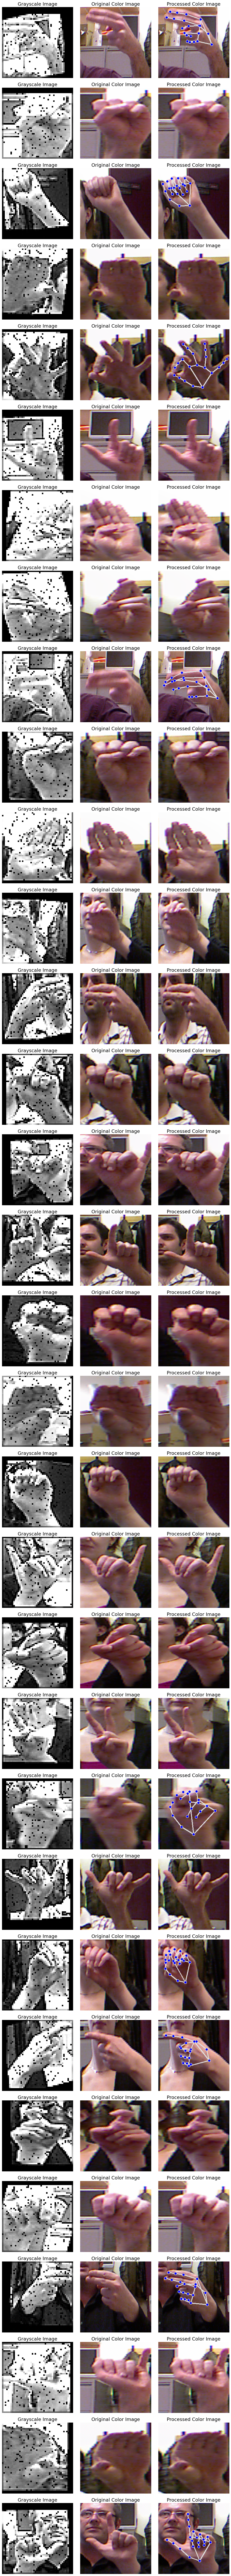

0.28125


In [50]:
import matplotlib.pyplot as plt

# Create batch of landmark processed images - full image annotation
def process_with_mediapipe_full(color_images):
    processed_images = []
    count_coord = 0
    for color_image in color_images:
        color_image_np = color_image.permute(1, 2, 0).numpy()
        color_image_np = (color_image_np * 255).astype(np.uint8)  # Convert to uint8
        color_image_np = np.ascontiguousarray(color_image_np)  # Ensure contiguous array
        results = mp_hands.process(color_image_np)
        if results.multi_hand_landmarks:
            count_coord += 1
            for hand_landmarks in results.multi_hand_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(
                    color_image_np, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)
        color_image_np = color_image_np.astype(np.float32) / 255.0  # Convert back to float32
        processed_images.append(torch.tensor(color_image_np).permute(2, 0, 1))
    return torch.stack(processed_images), count_coord



# Function to visualize a batch of images
def visualize_batch(grayscale_images, color_images, processed_color_images):
    batch_size = grayscale_images.size(0)

    fig, axes = plt.subplots(batch_size, 3, figsize=(12, batch_size * 4))
    for i in range(batch_size):
        # Grayscale image
        axes[i, 0].imshow(grayscale_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('Grayscale Image')
        axes[i, 0].axis('off')

        # Original color image
        axes[i, 1].imshow(color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 1].set_title('Original Color Image')
        axes[i, 1].axis('off')

        # Processed color image with MediaPipe landmarks
        axes[i, 2].imshow(processed_color_images[i].permute(1, 2, 0).cpu().numpy())
        axes[i, 2].set_title('Processed Color Image')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Fetch a single batch of images from the DataLoader
data_iter = iter(train_loader)
grayscale_images, color_images, labels = next(data_iter)

# Process color images with MediaPipe
processed_color_images, count_coord = process_with_mediapipe_full(color_images)

# Visualize the batch
visualize_batch(grayscale_images, color_images, processed_color_images)

print(count_coord/len(color_images))
